# Simple Neural Network Coffee Rosting

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)
plt.style.use("fivethirtyeight")

## Write a function to Create a random dataset

In [2]:
def load_coffee_data():
    rng = np.random.default_rng(2)
    X = rng.random(400).reshape(-1, 2)

    X[:, 1] = X[:, 1] * 4 + 11.5   # Sets tht time for rosting inbetween 11.5 to 15.5 min
    X[:, 0] = X[:, 0] * (285 - 150)  + 150   # Sets the temperature for rosting inbetween 150 and 285

    Y = np.zeros(len(X))
    i=0
    for t,d in X:
        y = -3/(260-175)*t + 21
        if (t > 175 and t < 260 and d > 12 and d < 15 and d<=y ):
            Y[i] = 1
        else:
            Y[i] = 0
        i += 1

    return (X, Y.reshape(-1,1))

In [3]:
X, y = load_coffee_data()

In [4]:
X[:4]

array([[185.31763812,  12.69396457],
       [259.92047498,  11.86766377],
       [231.01357101,  14.41424211],
       [175.3666449 ,  11.72058651]])

In [5]:
y[:4]

array([[1.],
       [0.],
       [0.],
       [0.]])

## Plot the coffee rosting data

C:\Users\abhis\AppData\Local\Temp\ipykernel_18436\1525798020.py:6: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(X[:, 0].reshape(-1, 1)[pos], X[:, 1].reshape(-1, 1)[pos], marker="x", c="r", label="Good Roast", s=100, edgecolor="black")


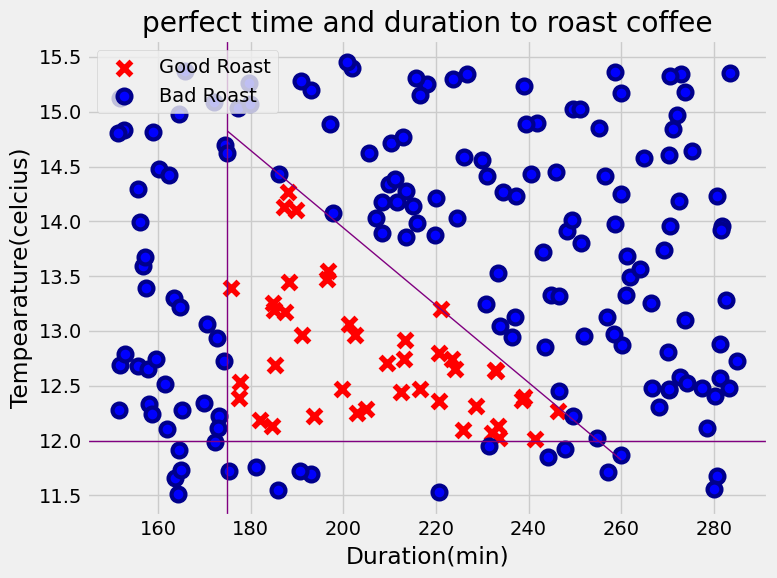

In [6]:
pos = y == 1
neg = y == 0

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.scatter(X[:, 0].reshape(-1, 1)[pos], X[:, 1].reshape(-1, 1)[pos], marker="x", c="r", label="Good Roast", s=100, edgecolor="black")
ax.scatter(X[:, 0].reshape(-1, 1)[neg], X[:, 1].reshape(-1, 1)[neg], marker="o", c="b", label="Bad Roast", s=100, facecolor='none', lw=3, edgecolor="darkblue")

tr = np.linspace(175,260,50)
ax.plot(tr, (-3/85) * tr + 21, c="purple", lw=1)
ax.axhline(y=12, c="purple", lw=1)
ax.axvline(x=175, c="purple", lw=1)

ax.set_title("perfect time and duration to roast coffee")
ax.set_xlabel("Duration(min)")
ax.set_ylabel("Tempearature(celcius)")
ax.legend(loc="upper left")
plt.tight_layout()

## Normalize the Data
Fitting the weights to the data (back-propagation, covered in next week's lectures) will proceed more quickly if the data is normalized. This is the same procedure you used in Course 1 where features in the data are each normalized to have a similar range. 
The procedure below uses a Keras [normalization layer](https://keras.io/api/layers/preprocessing_layers/numerical/normalization/). It has the following steps:
- create a "Normalization Layer". Note, as applied here, this is not a layer in your model.
- 'adapt' the data. This learns the mean and variance of the data set and saves the values internally.
- normalize the data.  
It is important to apply normalization to any future data that utilizes the learned model.

In [12]:
print(f"Temperature without Normalization, Max: {np.max(X[:, 0])}, Min: {np.min(X[:, 0])}")
print(f"Duration without Normalization, Max: {np.max(X[:, 1])}, Min: {np.min(X[:, 1])}")

norm_1 = tf.keras.layers.Normalization(axis=-1)
norm_1.adapt(X)
Xn = norm_1(X)

print(f"Temperature After Normalization, Max: {np.max(Xn[:, 0])}, Min: {np.min(Xn[:, 0])}")
print(f"Duration After Normalization, Max: {np.max(Xn[:, 0])}, Min: {np.min(Xn[:, 1])}")

Temperature without Normalization, Max: 284.99434167453603, Min: 151.32372212128612
Duration without Normalization, Max: 15.454206928801511, Min: 11.512747082472469
Temperature After Normalization, Max: 1.659753680229187, Min: -1.6852186918258667
Duration After Normalization, Max: 1.659753680229187, Min: -1.6996712684631348


In [16]:
Xt = np.tile(Xn,(1000,1))
yt= np.tile(y,(1000,1))   
print(Xt.shape, yt.shape)

(200000, 2) (200000, 1)


The tile method form numpy is used to copy the dataset in given number of times

## Build a Tensorflow model

In [17]:
tf.random.set_seed(1234)  # To obtain the consistant result

In [18]:
model = Sequential(
    [
        tf.keras.Input(shape=(2,)),
        Dense(units=3, activation='sigmoid', name="L1"),
        Dense(units=1, activation='sigmoid', name="L2")
    ]
)

>**Note 1:** The `tf.keras.Input(shape=(2,)),` specifies the expected shape of the input. This allows Tensorflow to size the weights and bias parameters at this point.  This is useful when exploring Tensorflow models. This statement can be omitted in practice and Tensorflow will size the network parameters when the input data is specified in the `model.fit` statement.  
>**Note 2:** Including the sigmoid activation in the final layer is not considered best practice. It would instead be accounted for in the loss which improves numerical stability. This will be described in more detail in a later lab.

The `model.summary()` provides a description of the network:

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 L1 (Dense)                  (None, 3)                 9         
                                                                 
 L2 (Dense)                  (None, 1)                 4         
                                                                 
Total params: 13 (52.00 Byte)
Trainable params: 13 (52.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [20]:
model.get_layer('L1').get_weights()

[array([[ 0.866019  , -0.1246351 ,  0.97561526],
        [ 0.8714274 , -0.24733931,  0.36360788]], dtype=float32),
 array([0., 0., 0.], dtype=float32)]

In [21]:
model.get_layer("L2").get_weights()

[array([[-1.0773184],
        [-0.6688512],
        [-1.0391634]], dtype=float32),
 array([0.], dtype=float32)]

- The `model.compile` statement defines a loss function and specifies a compile optimization.
- The `model.fit` statement runs gradient descent and fits the weights to the data.

In [23]:
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
)

model.fit(
    Xt, yt,
    epochs=10
)

Epoch 1/10
6250/6250 [==============================] - 10s 2ms/step - loss: 0.1607
Epoch 2/10
6250/6250 [==============================] - 8s 1ms/step - loss: 0.0883
Epoch 3/10
6250/6250 [==============================] - 7s 1ms/step - loss: 0.0228
Epoch 4/10
6250/6250 [==============================] - 7s 1ms/step - loss: 0.0132
Epoch 5/10
6250/6250 [==============================] - 7s 1ms/step - loss: 0.0090
Epoch 6/10
6250/6250 [==============================] - 5s 848us/step - loss: 0.0064
Epoch 7/10
6250/6250 [==============================] - 6s 885us/step - loss: 0.0045
Epoch 8/10
6250/6250 [==============================] - 5s 854us/step - loss: 0.0032
Epoch 9/10
6250/6250 [==============================] - 6s 892us/step - loss: 0.0024
Epoch 10/10
6250/6250 [==============================] - 6s 882us/step - loss: 0.0018


In [25]:
W1, b1 = model.get_layer("L1").get_weights()
W2, b2 = model.get_layer("L2").get_weights()
print("W1:\n", W1, "\nb1:", b1)
print("W2:\n", W2, "\nb2:", b2)

W1:
 [[ 14.330051   -11.164524    -0.13760358]
 [ 11.881696    -0.2564293   -8.953825  ]] 
b1: [  1.7828435 -12.169137  -11.201578 ]
W2:
 [[-44.1348  ]
 [-51.88712 ]
 [-47.322887]] 
b2: [27.085228]


In [27]:
X_test = np.array([
    [200,13.9],  # postive example
    [200,17]])   # negative example
X_testn = norm_1(X_test)
predictions = model.predict(X_testn)
print("predictions = \n", predictions)

1/1 [==============================] - 0s 59ms/step
predictions = 
 [[9.9042469e-01]
 [3.8539476e-08]]


#### Epochs and batches
In the `compile` statement above, the number of `epochs` was set to 10. This specifies that the entire data set should be applied during training 10 times.  During training, you see output describing the progress of training that looks like this:
```
Epoch 1/10
6250/6250 [==============================] - 6s 910us/step - loss: 0.1782
```
The first line, `Epoch 1/10`, describes which epoch the model is currently running. For efficiency, the training data set is broken into 'batches'. The default size of a batch in Tensorflow is 32. There are 200000 examples in our expanded data set or 6250 batches. The notation on the 2nd line `6250/6250 [====` is describing which batch has been executed.

In [28]:
yhat = (predictions >= 0.5).astype(int)

In [50]:
import matplotlib.colors as colors
from matplotlib import cm
dlc = dict(dlblue = '#0096ff', dlorange = '#FF9300', dldarkred='#C00000', dlmagenta='#FF40FF', dlpurple='#7030A0', dldarkblue =  '#0D5BDC')
def plt_prob(ax,fwb):
    """ plots a decision boundary but include shading to indicate the probability """
    #setup useful ranges and common linspaces
    x0_space  = np.linspace(150, 285 , 40)
    x1_space  = np.linspace(11.5, 15.5 , 40)

    # get probability for x0,x1 ranges
    tmp_x0,tmp_x1 = np.meshgrid(x0_space,x1_space)
    z = np.zeros_like(tmp_x0)
    for i in range(tmp_x0.shape[0]):
        for j in range(tmp_x1.shape[1]):
            x = np.array([[tmp_x0[i,j],tmp_x1[i,j]]])
            z[i,j] = fwb(x)


    cmap = plt.get_cmap('Blues')
    new_cmap = truncate_colormap(cmap, 0.0, 0.5)
    pcm = ax.pcolormesh(tmp_x0, tmp_x1, z,
                   norm=cm.colors.Normalize(vmin=0, vmax=1),
                   cmap=new_cmap, shading='nearest', alpha = 0.9)
    ax.figure.colorbar(pcm, ax=ax)

In [44]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    """ truncates color map """
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [41]:
def plt_layer(X,Y,W1,b1,norm_l):
    Y = Y.reshape(-1,)
    fig,ax = plt.subplots(1,W1.shape[1], figsize=(16,4))
    for i in range(W1.shape[1]):
        layerf= lambda x : sigmoid(np.dot(norm_l(x),W1[:,i]) + b1[i])
        plt_prob(ax[i], layerf)
        ax[i].scatter(X[Y==1,0],X[Y==1,1], s=70, marker='x', c='red', label="Good Roast" )
        ax[i].scatter(X[Y==0,0],X[Y==0,1], s=100, marker='o', facecolors='none', 
                   edgecolors=dlc["dldarkblue"],linewidth=1,  label="Bad Roast")
        tr = np.linspace(175,260,50)
        ax[i].plot(tr, (-3/85) * tr + 21, color=dlc["dlpurple"],linewidth=2)
        ax[i].axhline(y= 12, color=dlc["dlpurple"], linewidth=2)
        ax[i].axvline(x=175, color=dlc["dlpurple"], linewidth=2)
        ax[i].set_title(f"Layer 1, unit {i}")
        ax[i].set_xlabel("Temperature \n(Celsius)",size=12)
    ax[0].set_ylabel("Duration \n(minutes)",size=12)
    plt.show()

In [42]:
def sigmoid(z):
    z = np.clip(z, -500, 500)
    return 1.0/ (1.0 + np.exp(-z))

C:\Users\abhis\AppData\Local\Temp\ipykernel_18436\227063081.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  z[i,j] = fwb(x)


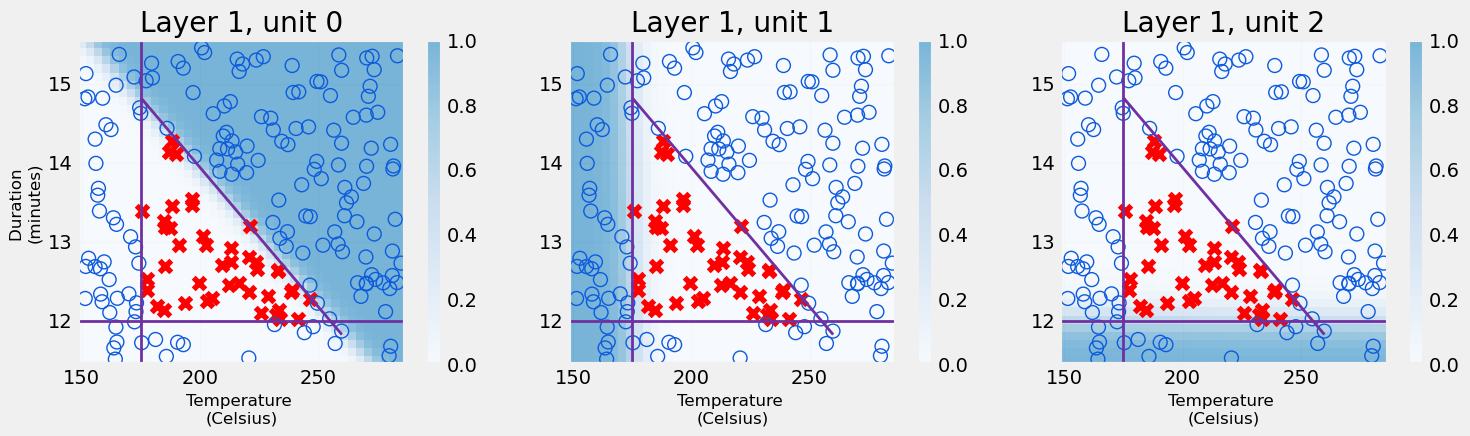

In [51]:
plt_layer(X,y.reshape(-1,),W1,b1,norm_1)